<a href="https://colab.research.google.com/github/Melsonwang1/CVNL-assignment/blob/main/CNN_final_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive/Colab\ Notebooks/


'archive (4).zip'		     'CNN_(3)_(1)_(1)_(1)_(1).ipynb'  'CNN_(3)_(1) (1).ipynb'
'CNN_(3)_(1)_(1)_(1)_(1) (1).ipynb'  'CNN_(3)_(1)_(1) (1).ipynb'


In [ ]:
!unzip "/content/drive/MyDrive/Colab Notebooks/archive (4).zip" -d "/content/asl_dataset"


Streaming output truncated to the last 5000 lines.
  inflating: /content/asl_dataset/ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2863).jpg  
  inflating: /content/asl_dataset/ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2864).jpg  
  inflating: /content/asl_dataset/ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2865).jpg  
  inflating: /content/asl_dataset/ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2866).jpg  
  inflating: /content/asl_dataset/ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2867).jpg  
  inflating: /content/asl_dataset/ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2868).jpg  
  inflating: /content/asl_dataset/ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2869).jpg  
  inflating: /content/asl_dataset/ASL_Alphabet_Dataset/asl_alphabet_train/space/space (287).jpg  
  inflating: /content/asl_dataset/ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2870).jpg  
  inflating: /content/asl_dataset/ASL_Alphabet_Dataset/asl_

In [ ]:
!ls /content/asl_dataset


ASL_Alphabet_Dataset


In [ ]:
import torchvision
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch.utils.data import DataLoader,Subset,random_split
import torch.nn as nn
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score,precision_score, recall_score,confusion_matrix, ConfusionMatrixDisplay
from torchvision.utils import make_grid
import torch.optim as optim
from torch.optim import SGD
import random


In [ ]:
# Check training directory
!ls /content/asl_dataset/ASL_Alphabet_Dataset/asl_alphabet_train

# Check testing directory
!ls /content/asl_dataset/ASL_Alphabet_Dataset/asl_alphabet_test

A  B  C  D  del  E  F  G  H  I	J  K  L  M  N  nothing	O  P  Q  R  S  space  T  U  V  W  X  Y	Z
A_test.jpg  E_test.jpg	I_test.jpg  M_test.jpg	      P_test.jpg      S_test.jpg  W_test.jpg
B_test.jpg  F_test.jpg	J_test.jpg  nothing_test.jpg  Q_test.jpg      T_test.jpg  X_test.jpg
C_test.jpg  G_test.jpg	K_test.jpg  N_test.jpg	      R_test.jpg      U_test.jpg  Y_test.jpg
D_test.jpg  H_test.jpg	L_test.jpg  O_test.jpg	      space_test.jpg  V_test.jpg  Z_test.jpg


In [ ]:
import os
import shutil

# Path to the test dataset
test_path = '/content/asl_dataset/ASL_Alphabet_Dataset/asl_alphabet_test'

# Reorganize test dataset into subfolders by class
for file in os.listdir(test_path):
    if file.endswith('.jpg'):
        # Extract the class name from the file name (e.g., 'a_test.jpg' -> 'a')
        class_name = file.split('_')[0].lower()
        class_dir = os.path.join(test_path, class_name)

        # Create a directory for the class if it doesn't already exist
        if not os.path.exists(class_dir):
            os.makedirs(class_dir)

        # Move the file to the corresponding class directory
        shutil.move(os.path.join(test_path, file), os.path.join(class_dir, file))

In [ ]:
# Check reorganized testing directory
!ls /content/asl_dataset/ASL_Alphabet_Dataset/asl_alphabet_test

# Check a specific class in the test directory (e.g., 'a' class)
!ls /content/asl_dataset/ASL_Alphabet_Dataset/asl_alphabet_test/a

a  b  c  d  e  f  g  h	i  j  k  l  m  n  nothing  o  p  q  r  s  space  t  u  v  w  x	y  z
A_test.jpg


In [ ]:
# Check for CUDA device
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

In [ ]:
# Define transformations: Resize, Convert to Tensor, Normalize
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize images to 64x64
    transforms.ToTensor(),        # Convert image to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Load the dataset
dataset = datasets.ImageFolder('/content/asl_dataset/ASL_Alphabet_Dataset/asl_alphabet_train', transform=transform)

# Define the percentages for training and validation
train_percentage = 0.2  # 60% of the dataset
val_percentage = 0.06    # 10% of the dataset

# Compute the sizes for each subset
train_size = int(train_percentage * len(dataset))
val_size = int(val_percentage * len(dataset))

# Ensure the remaining dataset (30%) isn't used
unused_size = len(dataset) - train_size - val_size

# Split the dataset into train, validation, and unused subsets
train_subset, val_dataset, _ = random_split(dataset, [train_size, val_size, unused_size])

# Create data loaders for train and validation subsets
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Print the sizes of each subset
print(f"Training dataset size: {len(train_subset)}")
print(f"Validation dataset size: {len(val_dataset)}")

Training dataset size: 44614
Validation dataset size: 13384


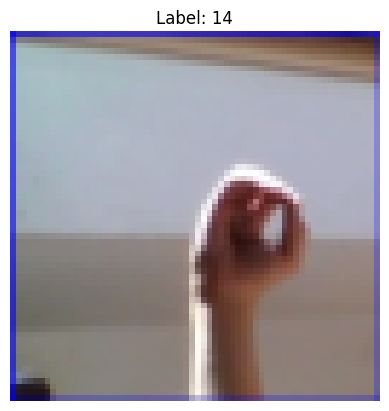

In [ ]:
# Retrieve a single batch from the train_loader
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Unnormalize the first image back to [0, 1]
image = images[0] * 0.5 + 0.5  # Undo normalization
image = image.numpy().transpose((1, 2, 0))  # Convert to numpy array for plotting

# Plot the image
plt.imshow(image)
plt.title(f"Label: {labels[0]}")
plt.axis("off")
plt.show()

In [ ]:
class ASLCNN(nn.Module):
    def __init__(self, num_classes=29):
        super(ASLCNN, self).__init__()

        # Convolutional Layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)  # New convolutional layer
        self.bn3 = nn.BatchNorm2d(128)  # BatchNorm for conv3

        # Max Pooling & Activation
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()

        # Dropout for regularization
        self.dropout = nn.Dropout(0.2)

        # Fully Connected Layers
        self.flattened_size = None
        self.fc1 = None
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))  # Conv -> BN -> ReLU
        x = self.pool(x)
        x = self.relu(self.bn2(self.conv2(x)))  # Conv -> BN -> ReLU
        x = self.pool(x)
        x = self.relu(self.bn3(self.conv3(x)))  # Conv -> BN -> ReLU (for conv3)
        x = self.pool(x)

        # Dynamically compute flattened size
        if self.flattened_size is None:
            self.flattened_size = x.view(x.size(0), -1).size(1)
            self.fc1 = nn.Linear(self.flattened_size, 512).to(x.device)

        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))  # Fully connected layer
        x = self.dropout(x)  # Dropout for regularization
        x = self.fc2(x)  # Output layer
        return x


In [ ]:
# Function to train the model with a given optimizer
def train_with_optimizer(optimizer_name, optimizer_class, model, train_loader, num_epochs=20, **optimizer_params):
    print(f"\nTraining with {optimizer_name} optimizer...")
    model = ASLCNN(num_classes=29).to(device)  # Reinitialize the model for a fair comparison
    optimizer = optimizer_class(model.parameters(), **optimizer_params)
    criterion = nn.CrossEntropyLoss()

    model.train()
    loss_history = []
    accuracy_history = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}", unit="batch")

        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track metrics
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            progress_bar.set_postfix(loss=(running_loss / len(train_loader)))

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = correct / total
        loss_history.append(epoch_loss)
        accuracy_history.append(epoch_accuracy)

        print(f"Epoch {epoch + 1}: Loss = {epoch_loss:.4f}, Accuracy = {epoch_accuracy:.4f}")

    return loss_history, accuracy_history




i want to see which optimizer gives me the best accuracy with the lowest noise so that i can apply the best optimizer for this

Stocastic gradient descent

In [ ]:
# Optimizer parameters for SGD
optimizer_name = "SGD"
optimizer_class = SGD
params = {"lr": 0.01}
batch_size = 1  # SGD uses batch size 1

# Implement true stochastic gradient descent
num_samples_per_epoch = 1000  # Number of random samples to process in each epoch

# Train with SGD optimizer
loss_history = []
accuracy_history = []

# Model initialization
model = ASLCNN(num_classes=29)

for epoch in range(20):  # Number of epochs
    # Randomly sample indices for each epoch
    random_indices = random.sample(range(len(train_subset)), num_samples_per_epoch)
    sampled_subset = Subset(train_subset, random_indices)

    # Create a DataLoader for the sampled subset
    optimizer_train_loader = DataLoader(sampled_subset, batch_size=batch_size, shuffle=True)

    # Train for one epoch using the randomly sampled subset
    epoch_loss_history, epoch_accuracy_history = train_with_optimizer(
        optimizer_name, optimizer_class, model, optimizer_train_loader, num_epochs=1, **params
    )

    # Append results
    loss_history.extend(epoch_loss_history)
    accuracy_history.extend(epoch_accuracy_history)

# Save results
results_sgd = {"loss": loss_history, "accuracy": accuracy_history}



Training with SGD optimizer...


Epoch 1/1: 100%|██████████| 1000/1000 [00:10<00:00, 98.16batch/s, loss=3.34]


Epoch 1: Loss = 3.3433, Accuracy = 0.0760

Training with SGD optimizer...


Epoch 1/1: 100%|██████████| 1000/1000 [00:09<00:00, 102.78batch/s, loss=3.3]


Epoch 1: Loss = 3.2959, Accuracy = 0.0750

Training with SGD optimizer...


Epoch 1/1: 100%|██████████| 1000/1000 [00:07<00:00, 125.31batch/s, loss=3.33]


Epoch 1: Loss = 3.3258, Accuracy = 0.0820

Training with SGD optimizer...


Epoch 1/1: 100%|██████████| 1000/1000 [00:09<00:00, 110.45batch/s, loss=3.32]


Epoch 1: Loss = 3.3156, Accuracy = 0.0740

Training with SGD optimizer...


Epoch 1/1: 100%|██████████| 1000/1000 [00:08<00:00, 118.57batch/s, loss=3.36]


Epoch 1: Loss = 3.3572, Accuracy = 0.0550

Training with SGD optimizer...


Epoch 1/1: 100%|██████████| 1000/1000 [00:08<00:00, 118.19batch/s, loss=3.34]


Epoch 1: Loss = 3.3426, Accuracy = 0.0730

Training with SGD optimizer...


Epoch 1/1: 100%|██████████| 1000/1000 [00:09<00:00, 110.70batch/s, loss=3.34]


Epoch 1: Loss = 3.3450, Accuracy = 0.0780

Training with SGD optimizer...


Epoch 1/1: 100%|██████████| 1000/1000 [00:08<00:00, 124.20batch/s, loss=3.36]


Epoch 1: Loss = 3.3579, Accuracy = 0.0650

Training with SGD optimizer...


Epoch 1/1: 100%|██████████| 1000/1000 [00:08<00:00, 112.69batch/s, loss=3.32]


Epoch 1: Loss = 3.3226, Accuracy = 0.0730

Training with SGD optimizer...


Epoch 1/1: 100%|██████████| 1000/1000 [00:07<00:00, 126.53batch/s, loss=3.32]


Epoch 1: Loss = 3.3164, Accuracy = 0.0650

Training with SGD optimizer...


Epoch 1/1: 100%|██████████| 1000/1000 [00:09<00:00, 111.11batch/s, loss=3.34]


Epoch 1: Loss = 3.3422, Accuracy = 0.0750

Training with SGD optimizer...


Epoch 1/1: 100%|██████████| 1000/1000 [00:08<00:00, 120.05batch/s, loss=3.34]


Epoch 1: Loss = 3.3379, Accuracy = 0.0540

Training with SGD optimizer...


Epoch 1/1: 100%|██████████| 1000/1000 [00:08<00:00, 117.50batch/s, loss=3.37]


Epoch 1: Loss = 3.3716, Accuracy = 0.0490

Training with SGD optimizer...


Epoch 1/1: 100%|██████████| 1000/1000 [00:08<00:00, 115.65batch/s, loss=3.35]


Epoch 1: Loss = 3.3499, Accuracy = 0.0740

Training with SGD optimizer...


Epoch 1/1: 100%|██████████| 1000/1000 [00:07<00:00, 126.16batch/s, loss=3.3]


Epoch 1: Loss = 3.3033, Accuracy = 0.0910

Training with SGD optimizer...


Epoch 1/1: 100%|██████████| 1000/1000 [00:08<00:00, 111.27batch/s, loss=3.33]


Epoch 1: Loss = 3.3336, Accuracy = 0.0700

Training with SGD optimizer...


Epoch 1/1: 100%|██████████| 1000/1000 [00:08<00:00, 123.04batch/s, loss=3.33]


Epoch 1: Loss = 3.3311, Accuracy = 0.0740

Training with SGD optimizer...


Epoch 1/1: 100%|██████████| 1000/1000 [00:10<00:00, 99.11batch/s, loss=3.35]


Epoch 1: Loss = 3.3454, Accuracy = 0.0710

Training with SGD optimizer...


Epoch 1/1: 100%|██████████| 1000/1000 [00:08<00:00, 117.18batch/s, loss=3.34]


Epoch 1: Loss = 3.3443, Accuracy = 0.0740

Training with SGD optimizer...


Epoch 1/1: 100%|██████████| 1000/1000 [00:08<00:00, 119.35batch/s, loss=3.33]

Epoch 1: Loss = 3.3349, Accuracy = 0.0670


mini batch gradient descent

In [ ]:
# Optimizer parameters for Mini-batch Gradient Descent
optimizer_name = "Mini-batch Gradient Descent (MBGD)"
optimizer_class = SGD
params = {"lr": 0.01}
batch_size = 64  # Mini-batch gradient descent uses a larger batch size

# Create a data loader for the current batch size
optimizer_train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)

# Train with MBGD optimizer
loss_history, accuracy_history = train_with_optimizer(
    optimizer_name, optimizer_class, ASLCNN(num_classes=29), optimizer_train_loader, num_epochs=20, **params
)


results_mbgd = {"loss": loss_history, "accuracy": accuracy_history}



Training with Mini-batch Gradient Descent (MBGD) optimizer...


Epoch 1/20: 100%|██████████| 698/698 [01:46<00:00,  6.56batch/s, loss=3.04]


Epoch 1: Loss = 3.0436, Accuracy = 0.1789


Epoch 2/20: 100%|██████████| 698/698 [01:30<00:00,  7.68batch/s, loss=2.39]


Epoch 2: Loss = 2.3927, Accuracy = 0.3754


Epoch 3/20: 100%|██████████| 698/698 [01:31<00:00,  7.64batch/s, loss=1.92]


Epoch 3: Loss = 1.9177, Accuracy = 0.5000


Epoch 4/20: 100%|██████████| 698/698 [01:28<00:00,  7.87batch/s, loss=1.6]


Epoch 4: Loss = 1.5992, Accuracy = 0.5832


Epoch 5/20: 100%|██████████| 698/698 [01:29<00:00,  7.79batch/s, loss=1.37]


Epoch 5: Loss = 1.3709, Accuracy = 0.6425


Epoch 6/20: 100%|██████████| 698/698 [01:31<00:00,  7.62batch/s, loss=1.2]


Epoch 6: Loss = 1.1984, Accuracy = 0.6873


Epoch 7/20: 100%|██████████| 698/698 [01:29<00:00,  7.82batch/s, loss=1.06]


Epoch 7: Loss = 1.0590, Accuracy = 0.7257


Epoch 8/20: 100%|██████████| 698/698 [01:31<00:00,  7.66batch/s, loss=0.949]


Epoch 8: Loss = 0.9494, Accuracy = 0.7562


Epoch 9/20: 100%|██████████| 698/698 [01:30<00:00,  7.71batch/s, loss=0.856]


Epoch 9: Loss = 0.8563, Accuracy = 0.7789


Epoch 10/20: 100%|██████████| 698/698 [01:30<00:00,  7.72batch/s, loss=0.783]


Epoch 10: Loss = 0.7825, Accuracy = 0.7999


Epoch 11/20: 100%|██████████| 698/698 [01:30<00:00,  7.71batch/s, loss=0.71]


Epoch 11: Loss = 0.7104, Accuracy = 0.8197


Epoch 12/20: 100%|██████████| 698/698 [01:32<00:00,  7.54batch/s, loss=0.656]


Epoch 12: Loss = 0.6559, Accuracy = 0.8336


Epoch 13/20: 100%|██████████| 698/698 [01:30<00:00,  7.69batch/s, loss=0.608]


Epoch 13: Loss = 0.6078, Accuracy = 0.8454


Epoch 14/20: 100%|██████████| 698/698 [01:30<00:00,  7.69batch/s, loss=0.56]


Epoch 14: Loss = 0.5603, Accuracy = 0.8597


Epoch 15/20: 100%|██████████| 698/698 [01:30<00:00,  7.74batch/s, loss=0.525]


Epoch 15: Loss = 0.5246, Accuracy = 0.8671


Epoch 16/20: 100%|██████████| 698/698 [01:30<00:00,  7.74batch/s, loss=0.493]


Epoch 16: Loss = 0.4929, Accuracy = 0.8772


Epoch 17/20: 100%|██████████| 698/698 [01:29<00:00,  7.83batch/s, loss=0.462]


Epoch 17: Loss = 0.4622, Accuracy = 0.8841


Epoch 18/20: 100%|██████████| 698/698 [01:31<00:00,  7.64batch/s, loss=0.434]


Epoch 18: Loss = 0.4336, Accuracy = 0.8924


Epoch 19/20: 100%|██████████| 698/698 [01:30<00:00,  7.70batch/s, loss=0.411]


Epoch 19: Loss = 0.4110, Accuracy = 0.8986


Epoch 20/20: 100%|██████████| 698/698 [01:29<00:00,  7.83batch/s, loss=0.392]

Epoch 20: Loss = 0.3916, Accuracy = 0.9047


gradient descent cant be run as the processing of the entire dataset exceeds the memory capacity of the GPU

In [ ]:
# Optimizer parameters for Adam
optimizer_name = "Adam"
optimizer_class = optim.Adam
params = {"lr": 0.01}
batch_size = 64  # Mini-batch size for Adam

# Create a data loader for the current batch size
optimizer_train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)

# Train with Adam optimizer
loss_history, accuracy_history = train_with_optimizer(
    optimizer_name, optimizer_class, ASLCNN(num_classes=29), optimizer_train_loader, num_epochs=20, **params
)

# Save results
results_adam = {"loss": loss_history, "accuracy": accuracy_history}



Training with Adam optimizer...


Epoch 1/20: 100%|██████████| 698/698 [01:31<00:00,  7.65batch/s, loss=1.67]


Epoch 1: Loss = 1.6660, Accuracy = 0.5064


Epoch 2/20: 100%|██████████| 698/698 [01:31<00:00,  7.67batch/s, loss=0.776]


Epoch 2: Loss = 0.7763, Accuracy = 0.7636


Epoch 3/20: 100%|██████████| 698/698 [01:28<00:00,  7.86batch/s, loss=0.553]


Epoch 3: Loss = 0.5530, Accuracy = 0.8276


Epoch 4/20: 100%|██████████| 698/698 [01:30<00:00,  7.74batch/s, loss=0.437]


Epoch 4: Loss = 0.4365, Accuracy = 0.8647


Epoch 5/20: 100%|██████████| 698/698 [01:30<00:00,  7.69batch/s, loss=0.384]


Epoch 5: Loss = 0.3837, Accuracy = 0.8788


Epoch 6/20: 100%|██████████| 698/698 [01:29<00:00,  7.80batch/s, loss=0.322]


Epoch 6: Loss = 0.3219, Accuracy = 0.8968


Epoch 7/20: 100%|██████████| 698/698 [01:30<00:00,  7.72batch/s, loss=0.294]


Epoch 7: Loss = 0.2936, Accuracy = 0.9062


Epoch 8/20: 100%|██████████| 698/698 [01:28<00:00,  7.85batch/s, loss=0.264]


Epoch 8: Loss = 0.2637, Accuracy = 0.9163


Epoch 9/20: 100%|██████████| 698/698 [01:31<00:00,  7.63batch/s, loss=0.244]


Epoch 9: Loss = 0.2441, Accuracy = 0.9220


Epoch 10/20: 100%|██████████| 698/698 [01:30<00:00,  7.69batch/s, loss=0.222]


Epoch 10: Loss = 0.2218, Accuracy = 0.9274


Epoch 11/20: 100%|██████████| 698/698 [01:28<00:00,  7.87batch/s, loss=0.22]


Epoch 11: Loss = 0.2201, Accuracy = 0.9297


Epoch 12/20: 100%|██████████| 698/698 [01:30<00:00,  7.74batch/s, loss=0.2]


Epoch 12: Loss = 0.2003, Accuracy = 0.9346


Epoch 13/20: 100%|██████████| 698/698 [01:29<00:00,  7.82batch/s, loss=0.188]


Epoch 13: Loss = 0.1879, Accuracy = 0.9389


Epoch 14/20: 100%|██████████| 698/698 [01:31<00:00,  7.67batch/s, loss=0.174]


Epoch 14: Loss = 0.1737, Accuracy = 0.9430


Epoch 15/20: 100%|██████████| 698/698 [01:30<00:00,  7.72batch/s, loss=0.17]


Epoch 15: Loss = 0.1705, Accuracy = 0.9457


Epoch 16/20: 100%|██████████| 698/698 [01:28<00:00,  7.87batch/s, loss=0.163]


Epoch 16: Loss = 0.1629, Accuracy = 0.9474


Epoch 17/20: 100%|██████████| 698/698 [01:30<00:00,  7.71batch/s, loss=0.154]


Epoch 17: Loss = 0.1537, Accuracy = 0.9507


Epoch 18/20: 100%|██████████| 698/698 [01:31<00:00,  7.64batch/s, loss=0.154]


Epoch 18: Loss = 0.1540, Accuracy = 0.9485


Epoch 19/20: 100%|██████████| 698/698 [01:28<00:00,  7.87batch/s, loss=0.136]


Epoch 19: Loss = 0.1355, Accuracy = 0.9563


Epoch 20/20: 100%|██████████| 698/698 [01:30<00:00,  7.71batch/s, loss=0.143]

Epoch 20: Loss = 0.1426, Accuracy = 0.9532


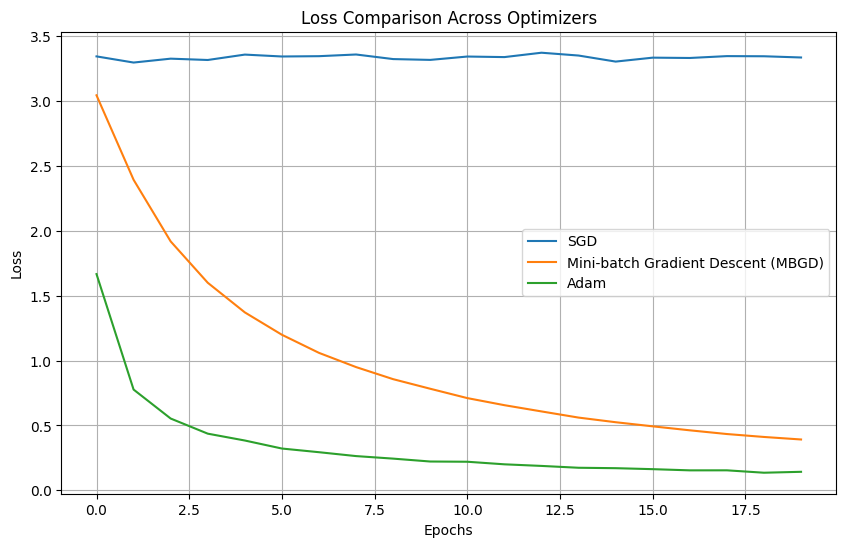

In [ ]:
results = {
    "SGD": results_sgd,
    "Mini-batch Gradient Descent (MBGD)": results_mbgd,
    "Adam": results_adam
}

# Plot the loss comparison across optimizers
plt.figure(figsize=(10, 6))

for optimizer_name, result in results.items():
    plt.plot(result["loss"], label=optimizer_name)

plt.title('Loss Comparison Across Optimizers')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

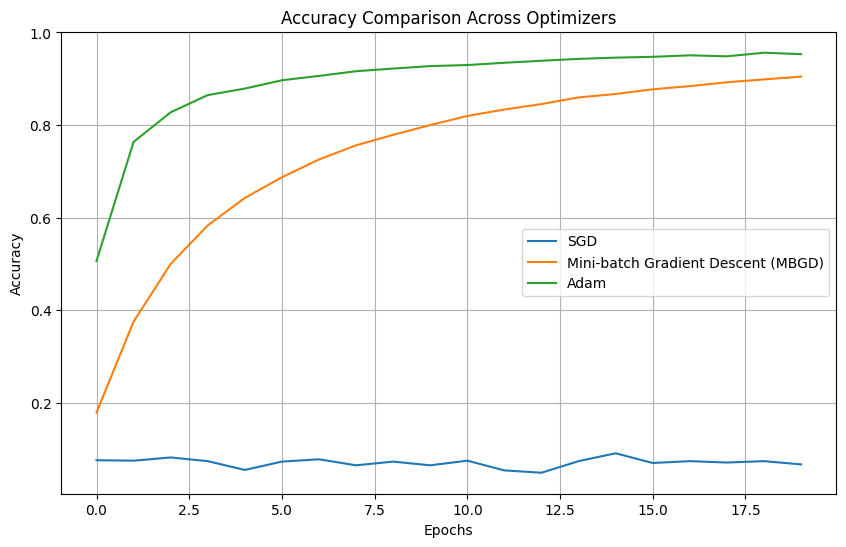

In [ ]:
plt.figure(figsize=(10, 6))

for optimizer_name, result in results.items():
    plt.plot(result["accuracy"], label=optimizer_name)

plt.title('Accuracy Comparison Across Optimizers')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

the accuracy shows that adam is the most accurate among the 3 algorithm  and also has the least loss meaning that it is closest to the actual values as compared to the rest

since now we know that adam is the best in terms of accuracy and loss we now have to tune the learning rate and decide which is the best for adam and make sure to prevent overfitting and underfitting

In [ ]:
def train_with_learning_rates(model_class, train_loader, num_epochs, learning_rates, device):
    results = {}

    for lr in learning_rates:
        print(f"\nTraining with Adam optimizer and learning rate = {lr}...")
        model = model_class(num_classes=29).to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        model.train()
        loss_history = []
        accuracy_history = []

        for epoch in range(num_epochs):
            running_loss = 0.0
            correct = 0
            total = 0
            progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}", unit="batch")

            for inputs, labels in progress_bar:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Backward pass
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Track metrics
                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

                progress_bar.set_postfix(loss=(running_loss / len(train_loader)))

            epoch_loss = running_loss / len(train_loader)
            epoch_accuracy = correct / total
            loss_history.append(epoch_loss)
            accuracy_history.append(epoch_accuracy)

            print(f"Learning Rate {lr} - Epoch {epoch + 1}: Loss = {epoch_loss:.4f}, Accuracy = {epoch_accuracy:.4f}")

        # Save the history for this learning rate
        results[lr] = {"loss": loss_history, "accuracy": accuracy_history}

    return results


In [ ]:
learning_rates = [0.01, 0.001]  # cannot have too many as it takes too long to train
num_epochs = 20

results_adam_lr = train_with_learning_rates(
    ASLCNN,
    train_loader,
    num_epochs,
    learning_rates,
    device
)



Training with Adam optimizer and learning rate = 0.01...


Epoch 1/20: 100%|██████████| 698/698 [01:30<00:00,  7.75batch/s, loss=1.71]


Learning Rate 0.01 - Epoch 1: Loss = 1.7064, Accuracy = 0.4958


Epoch 2/20: 100%|██████████| 698/698 [01:31<00:00,  7.67batch/s, loss=0.829]


Learning Rate 0.01 - Epoch 2: Loss = 0.8288, Accuracy = 0.7448


Epoch 3/20: 100%|██████████| 698/698 [01:30<00:00,  7.73batch/s, loss=0.602]


Learning Rate 0.01 - Epoch 3: Loss = 0.6023, Accuracy = 0.8125


Epoch 4/20: 100%|██████████| 698/698 [01:29<00:00,  7.81batch/s, loss=0.475]


Learning Rate 0.01 - Epoch 4: Loss = 0.4753, Accuracy = 0.8516


Epoch 5/20: 100%|██████████| 698/698 [01:30<00:00,  7.69batch/s, loss=0.411]


Learning Rate 0.01 - Epoch 5: Loss = 0.4107, Accuracy = 0.8672


Epoch 6/20: 100%|██████████| 698/698 [01:29<00:00,  7.80batch/s, loss=0.356]


Learning Rate 0.01 - Epoch 6: Loss = 0.3555, Accuracy = 0.8885


Epoch 7/20: 100%|██████████| 698/698 [01:32<00:00,  7.58batch/s, loss=0.31]


Learning Rate 0.01 - Epoch 7: Loss = 0.3105, Accuracy = 0.9018


Epoch 8/20: 100%|██████████| 698/698 [01:32<00:00,  7.56batch/s, loss=0.293]


Learning Rate 0.01 - Epoch 8: Loss = 0.2927, Accuracy = 0.9059


Epoch 9/20: 100%|██████████| 698/698 [01:30<00:00,  7.73batch/s, loss=0.261]


Learning Rate 0.01 - Epoch 9: Loss = 0.2613, Accuracy = 0.9168


Epoch 10/20: 100%|██████████| 698/698 [01:33<00:00,  7.45batch/s, loss=0.251]


Learning Rate 0.01 - Epoch 10: Loss = 0.2511, Accuracy = 0.9188


Epoch 11/20: 100%|██████████| 698/698 [01:32<00:00,  7.54batch/s, loss=0.231]


Learning Rate 0.01 - Epoch 11: Loss = 0.2310, Accuracy = 0.9244


Epoch 12/20: 100%|██████████| 698/698 [01:31<00:00,  7.59batch/s, loss=0.214]


Learning Rate 0.01 - Epoch 12: Loss = 0.2144, Accuracy = 0.9307


Epoch 13/20: 100%|██████████| 698/698 [01:32<00:00,  7.56batch/s, loss=0.206]


Learning Rate 0.01 - Epoch 13: Loss = 0.2057, Accuracy = 0.9336


Epoch 14/20: 100%|██████████| 698/698 [01:29<00:00,  7.82batch/s, loss=0.186]


Learning Rate 0.01 - Epoch 14: Loss = 0.1858, Accuracy = 0.9397


Epoch 15/20: 100%|██████████| 698/698 [01:34<00:00,  7.39batch/s, loss=0.184]


Learning Rate 0.01 - Epoch 15: Loss = 0.1840, Accuracy = 0.9415


Epoch 16/20: 100%|██████████| 698/698 [01:31<00:00,  7.63batch/s, loss=0.177]


Learning Rate 0.01 - Epoch 16: Loss = 0.1768, Accuracy = 0.9425


Epoch 17/20: 100%|██████████| 698/698 [01:30<00:00,  7.73batch/s, loss=0.161]


Learning Rate 0.01 - Epoch 17: Loss = 0.1608, Accuracy = 0.9485


Epoch 18/20: 100%|██████████| 698/698 [01:32<00:00,  7.57batch/s, loss=0.167]


Learning Rate 0.01 - Epoch 18: Loss = 0.1671, Accuracy = 0.9466


Epoch 19/20: 100%|██████████| 698/698 [01:29<00:00,  7.79batch/s, loss=0.157]


Learning Rate 0.01 - Epoch 19: Loss = 0.1566, Accuracy = 0.9491


Epoch 20/20: 100%|██████████| 698/698 [01:31<00:00,  7.66batch/s, loss=0.154]


Learning Rate 0.01 - Epoch 20: Loss = 0.1539, Accuracy = 0.9502

Training with Adam optimizer and learning rate = 0.001...


Epoch 1/20: 100%|██████████| 698/698 [01:31<00:00,  7.63batch/s, loss=1.9]


Learning Rate 0.001 - Epoch 1: Loss = 1.8976, Accuracy = 0.4688


Epoch 2/20: 100%|██████████| 698/698 [01:29<00:00,  7.79batch/s, loss=0.859]


Learning Rate 0.001 - Epoch 2: Loss = 0.8589, Accuracy = 0.7578


Epoch 3/20: 100%|██████████| 698/698 [01:31<00:00,  7.62batch/s, loss=0.57]


Learning Rate 0.001 - Epoch 3: Loss = 0.5702, Accuracy = 0.8361


Epoch 4/20: 100%|██████████| 698/698 [01:29<00:00,  7.79batch/s, loss=0.43]


Learning Rate 0.001 - Epoch 4: Loss = 0.4302, Accuracy = 0.8780


Epoch 5/20: 100%|██████████| 698/698 [01:31<00:00,  7.62batch/s, loss=0.336]


Learning Rate 0.001 - Epoch 5: Loss = 0.3362, Accuracy = 0.9051


Epoch 6/20: 100%|██████████| 698/698 [01:31<00:00,  7.62batch/s, loss=0.28]


Learning Rate 0.001 - Epoch 6: Loss = 0.2798, Accuracy = 0.9185


Epoch 7/20: 100%|██████████| 698/698 [01:30<00:00,  7.75batch/s, loss=0.234]


Learning Rate 0.001 - Epoch 7: Loss = 0.2335, Accuracy = 0.9315


Epoch 8/20: 100%|██████████| 698/698 [01:32<00:00,  7.51batch/s, loss=0.209]


Learning Rate 0.001 - Epoch 8: Loss = 0.2090, Accuracy = 0.9382


Epoch 9/20: 100%|██████████| 698/698 [01:30<00:00,  7.73batch/s, loss=0.19]


Learning Rate 0.001 - Epoch 9: Loss = 0.1899, Accuracy = 0.9430


Epoch 10/20: 100%|██████████| 698/698 [01:31<00:00,  7.66batch/s, loss=0.173]


Learning Rate 0.001 - Epoch 10: Loss = 0.1732, Accuracy = 0.9462


Epoch 11/20: 100%|██████████| 698/698 [01:30<00:00,  7.70batch/s, loss=0.151]


Learning Rate 0.001 - Epoch 11: Loss = 0.1507, Accuracy = 0.9538


Epoch 12/20: 100%|██████████| 698/698 [01:30<00:00,  7.71batch/s, loss=0.141]


Learning Rate 0.001 - Epoch 12: Loss = 0.1411, Accuracy = 0.9571


Epoch 13/20: 100%|██████████| 698/698 [01:31<00:00,  7.66batch/s, loss=0.136]


Learning Rate 0.001 - Epoch 13: Loss = 0.1365, Accuracy = 0.9580


Epoch 14/20: 100%|██████████| 698/698 [01:31<00:00,  7.62batch/s, loss=0.116]


Learning Rate 0.001 - Epoch 14: Loss = 0.1159, Accuracy = 0.9643


Epoch 15/20: 100%|██████████| 698/698 [01:31<00:00,  7.63batch/s, loss=0.12]


Learning Rate 0.001 - Epoch 15: Loss = 0.1203, Accuracy = 0.9623


Epoch 16/20: 100%|██████████| 698/698 [01:30<00:00,  7.67batch/s, loss=0.108]


Learning Rate 0.001 - Epoch 16: Loss = 0.1076, Accuracy = 0.9667


Epoch 17/20: 100%|██████████| 698/698 [01:32<00:00,  7.58batch/s, loss=0.108]


Learning Rate 0.001 - Epoch 17: Loss = 0.1075, Accuracy = 0.9663


Epoch 18/20: 100%|██████████| 698/698 [01:31<00:00,  7.67batch/s, loss=0.094]


Learning Rate 0.001 - Epoch 18: Loss = 0.0940, Accuracy = 0.9705


Epoch 19/20: 100%|██████████| 698/698 [01:30<00:00,  7.70batch/s, loss=0.089]


Learning Rate 0.001 - Epoch 19: Loss = 0.0890, Accuracy = 0.9713


Epoch 20/20: 100%|██████████| 698/698 [01:30<00:00,  7.71batch/s, loss=0.0869]

Learning Rate 0.001 - Epoch 20: Loss = 0.0869, Accuracy = 0.9722


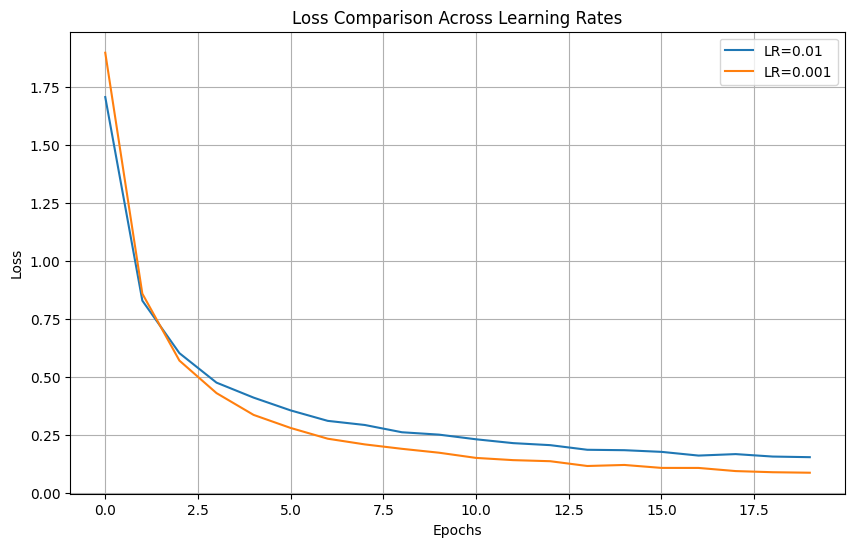

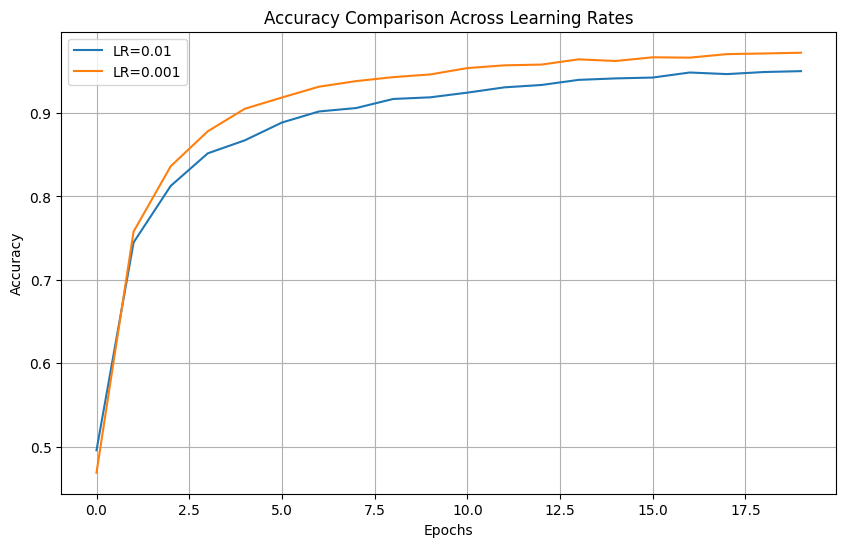

In [ ]:
# Plot the loss across learning rates
plt.figure(figsize=(10, 6))
for lr, result in results_adam_lr.items():
    plt.plot(result["loss"], label=f"LR={lr}")
plt.title('Loss Comparison Across Learning Rates')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot the accuracy across learning rates
plt.figure(figsize=(10, 6))
for lr, result in results_adam_lr.items():
    plt.plot(result["accuracy"], label=f"LR={lr}")
plt.title('Accuracy Comparison Across Learning Rates')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

from this 2 graph we can see that 0.001 works best



so now we can train the training dataset and compare it against the validation dataset

In [ ]:
# Initialize model, optimizer, and loss function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ASLCNN(num_classes=29).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [ ]:
# Metrics history
num_epochs = 20
train_loss_history, val_loss_history = [], []
train_accuracy_history, val_accuracy_history = [], []
val_f1_score_history, val_precision_history, val_recall_history = [], [], []

# Training and validation loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} (Training)", unit="batch")
    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track metrics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        progress_bar.set_postfix(loss=(running_loss / len(train_loader)))

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    train_loss_history.append(train_loss)
    train_accuracy_history.append(train_accuracy)

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        progress_bar = tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} (Validation)", unit="batch")
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Track metrics
            val_running_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

            # Store labels and predictions for F1, precision, and recall calculation
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    val_loss = val_running_loss / len(val_loader)
    val_accuracy = val_correct / val_total
    val_loss_history.append(val_loss)
    val_accuracy_history.append(val_accuracy)
    cm = confusion_matrix(all_labels, all_predictions)

    # Calculate F1 score, precision, and recall
    val_f1 = f1_score(all_labels, all_predictions, average="macro")
    val_precision = precision_score(all_labels, all_predictions, average="macro", zero_division=0)
    val_recall = recall_score(all_labels, all_predictions, average="macro", zero_division=0)

    val_f1_score_history.append(val_f1)
    val_precision_history.append(val_precision)
    val_recall_history.append(val_recall)

    print(f"Epoch {epoch + 1}: Train Loss = {train_loss:.4f}, Train Accuracy = {train_accuracy:.4f}, "
          f"Val Loss = {val_loss:.4f}, Val Accuracy = {val_accuracy:.4f}, "
          f"Val F1 Score = {val_f1:.4f}, Val Precision = {val_precision:.4f}, Val Recall = {val_recall:.4f}")


Epoch 1/20 (Validation): 100%|██████████| 210/210 [00:25<00:00,  8.40batch/s]


Epoch 1: Train Loss = 0.0634, Train Accuracy = 0.9801, Val Loss = 0.1273, Val Accuracy = 0.9688, Val F1 Score = 0.9698, Val Precision = 0.9703, Val Recall = 0.9697


Epoch 2/20 (Validation): 100%|██████████| 210/210 [00:24<00:00,  8.49batch/s]


Epoch 2: Train Loss = 0.0656, Train Accuracy = 0.9794, Val Loss = 0.1392, Val Accuracy = 0.9653, Val F1 Score = 0.9667, Val Precision = 0.9675, Val Recall = 0.9664


Epoch 3/20 (Validation): 100%|██████████| 210/210 [00:24<00:00,  8.50batch/s]


Epoch 3: Train Loss = 0.0687, Train Accuracy = 0.9777, Val Loss = 0.1272, Val Accuracy = 0.9701, Val F1 Score = 0.9711, Val Precision = 0.9716, Val Recall = 0.9712


Epoch 4/20 (Validation): 100%|██████████| 210/210 [00:24<00:00,  8.74batch/s]


Epoch 4: Train Loss = 0.0630, Train Accuracy = 0.9797, Val Loss = 0.1157, Val Accuracy = 0.9709, Val F1 Score = 0.9720, Val Precision = 0.9725, Val Recall = 0.9717


Epoch 5/20 (Validation): 100%|██████████| 210/210 [00:24<00:00,  8.57batch/s]


Epoch 5: Train Loss = 0.0639, Train Accuracy = 0.9793, Val Loss = 0.1181, Val Accuracy = 0.9728, Val F1 Score = 0.9737, Val Precision = 0.9741, Val Recall = 0.9735


Epoch 6/20 (Validation): 100%|██████████| 210/210 [00:23<00:00,  8.77batch/s]


Epoch 6: Train Loss = 0.0618, Train Accuracy = 0.9790, Val Loss = 0.1097, Val Accuracy = 0.9742, Val F1 Score = 0.9753, Val Precision = 0.9754, Val Recall = 0.9752


Epoch 7/20 (Validation): 100%|██████████| 210/210 [00:23<00:00,  8.85batch/s]


Epoch 7: Train Loss = 0.0582, Train Accuracy = 0.9809, Val Loss = 0.1123, Val Accuracy = 0.9726, Val F1 Score = 0.9735, Val Precision = 0.9735, Val Recall = 0.9736


Epoch 8/20 (Validation): 100%|██████████| 210/210 [00:23<00:00,  8.76batch/s]


Epoch 8: Train Loss = 0.0519, Train Accuracy = 0.9834, Val Loss = 0.1254, Val Accuracy = 0.9687, Val F1 Score = 0.9700, Val Precision = 0.9704, Val Recall = 0.9698


Epoch 9/20 (Validation): 100%|██████████| 210/210 [00:23<00:00,  8.89batch/s]


Epoch 9: Train Loss = 0.0619, Train Accuracy = 0.9803, Val Loss = 0.1192, Val Accuracy = 0.9704, Val F1 Score = 0.9713, Val Precision = 0.9715, Val Recall = 0.9712


Epoch 10/20 (Validation): 100%|██████████| 210/210 [00:24<00:00,  8.62batch/s]


Epoch 10: Train Loss = 0.0546, Train Accuracy = 0.9828, Val Loss = 0.1206, Val Accuracy = 0.9702, Val F1 Score = 0.9713, Val Precision = 0.9717, Val Recall = 0.9711


Epoch 11/20 (Validation): 100%|██████████| 210/210 [00:24<00:00,  8.74batch/s]


Epoch 11: Train Loss = 0.0542, Train Accuracy = 0.9818, Val Loss = 0.1253, Val Accuracy = 0.9685, Val F1 Score = 0.9696, Val Precision = 0.9698, Val Recall = 0.9695


Epoch 12/20 (Validation): 100%|██████████| 210/210 [00:24<00:00,  8.69batch/s]


Epoch 12: Train Loss = 0.0544, Train Accuracy = 0.9821, Val Loss = 0.1182, Val Accuracy = 0.9720, Val F1 Score = 0.9729, Val Precision = 0.9733, Val Recall = 0.9728


Epoch 13/20 (Validation): 100%|██████████| 210/210 [00:24<00:00,  8.64batch/s]


Epoch 13: Train Loss = 0.0530, Train Accuracy = 0.9826, Val Loss = 0.1308, Val Accuracy = 0.9685, Val F1 Score = 0.9696, Val Precision = 0.9700, Val Recall = 0.9695


Epoch 14/20 (Validation): 100%|██████████| 210/210 [00:24<00:00,  8.60batch/s]


Epoch 14: Train Loss = 0.0511, Train Accuracy = 0.9836, Val Loss = 0.1219, Val Accuracy = 0.9716, Val F1 Score = 0.9726, Val Precision = 0.9728, Val Recall = 0.9724


Epoch 15/20 (Validation): 100%|██████████| 210/210 [00:24<00:00,  8.70batch/s]


Epoch 15: Train Loss = 0.0470, Train Accuracy = 0.9843, Val Loss = 0.1188, Val Accuracy = 0.9718, Val F1 Score = 0.9728, Val Precision = 0.9731, Val Recall = 0.9726


Epoch 16/20 (Validation): 100%|██████████| 210/210 [00:24<00:00,  8.74batch/s]


Epoch 16: Train Loss = 0.0452, Train Accuracy = 0.9853, Val Loss = 0.1324, Val Accuracy = 0.9704, Val F1 Score = 0.9715, Val Precision = 0.9718, Val Recall = 0.9714


Epoch 17/20 (Validation): 100%|██████████| 210/210 [00:24<00:00,  8.65batch/s]


Epoch 17: Train Loss = 0.0414, Train Accuracy = 0.9867, Val Loss = 0.1231, Val Accuracy = 0.9697, Val F1 Score = 0.9707, Val Precision = 0.9707, Val Recall = 0.9709


Epoch 18/20 (Validation): 100%|██████████| 210/210 [00:24<00:00,  8.64batch/s]


Epoch 18: Train Loss = 0.0451, Train Accuracy = 0.9854, Val Loss = 0.1188, Val Accuracy = 0.9725, Val F1 Score = 0.9734, Val Precision = 0.9736, Val Recall = 0.9735


Epoch 19/20 (Validation): 100%|██████████| 210/210 [00:23<00:00,  8.80batch/s]


Epoch 19: Train Loss = 0.0480, Train Accuracy = 0.9844, Val Loss = 0.1266, Val Accuracy = 0.9708, Val F1 Score = 0.9717, Val Precision = 0.9719, Val Recall = 0.9717


Epoch 20/20 (Validation): 100%|██████████| 210/210 [00:24<00:00,  8.61batch/s]

Epoch 20: Train Loss = 0.0454, Train Accuracy = 0.9848, Val Loss = 0.1163, Val Accuracy = 0.9716, Val F1 Score = 0.9725, Val Precision = 0.9730, Val Recall = 0.9724


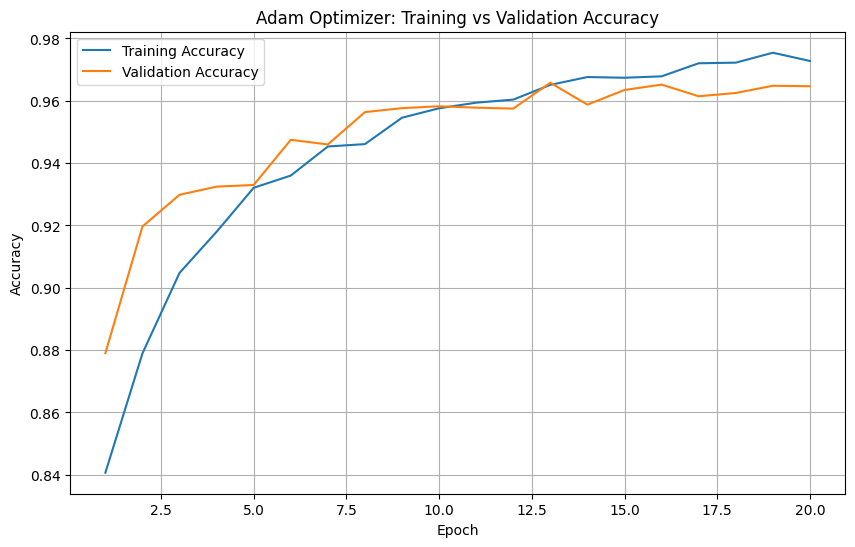

In [ ]:
# Plotting the graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_accuracy_history, label="Training Accuracy")
plt.plot(range(1, num_epochs + 1), val_accuracy_history, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Adam Optimizer: Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

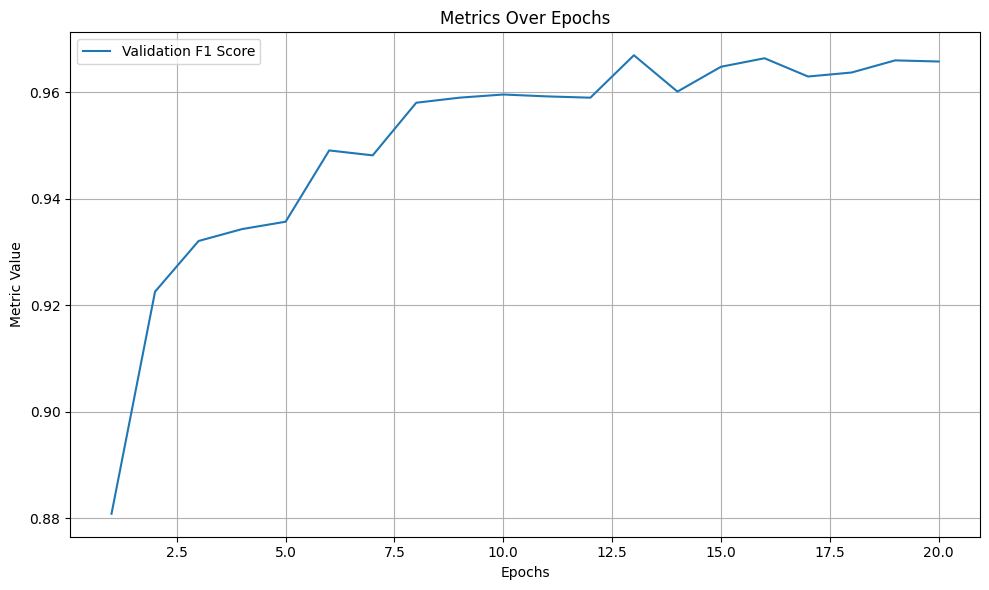

In [ ]:
# Plot training and validation metrics
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 6))

# Plot F1 Score
plt.plot(epochs, val_f1_score_history, label="Validation F1 Score")



# Customization
plt.title("Metrics Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Metric Value")
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

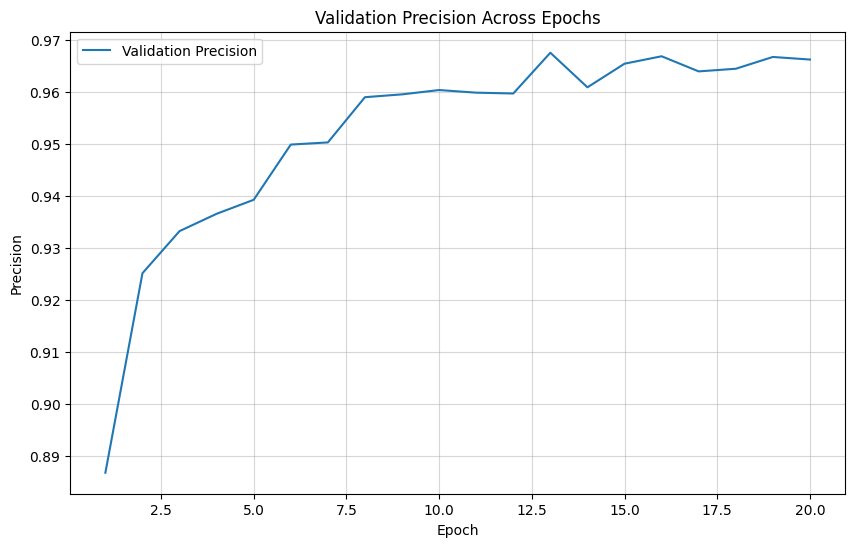

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), val_precision_history, label="Validation Precision")
plt.title("Validation Precision Across Epochs")
plt.xlabel("Epoch")
plt.ylabel("Precision")
plt.grid(alpha=0.5)
plt.legend()
plt.show()

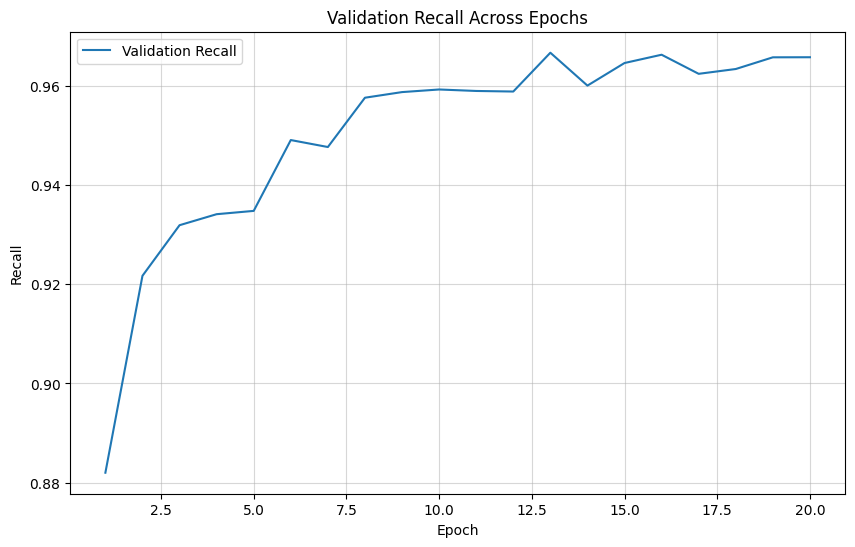

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), val_recall_history, label="Validation Recall")
plt.title("Validation Recall Across Epochs")
plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.grid(alpha=0.5)
plt.legend()
plt.show()

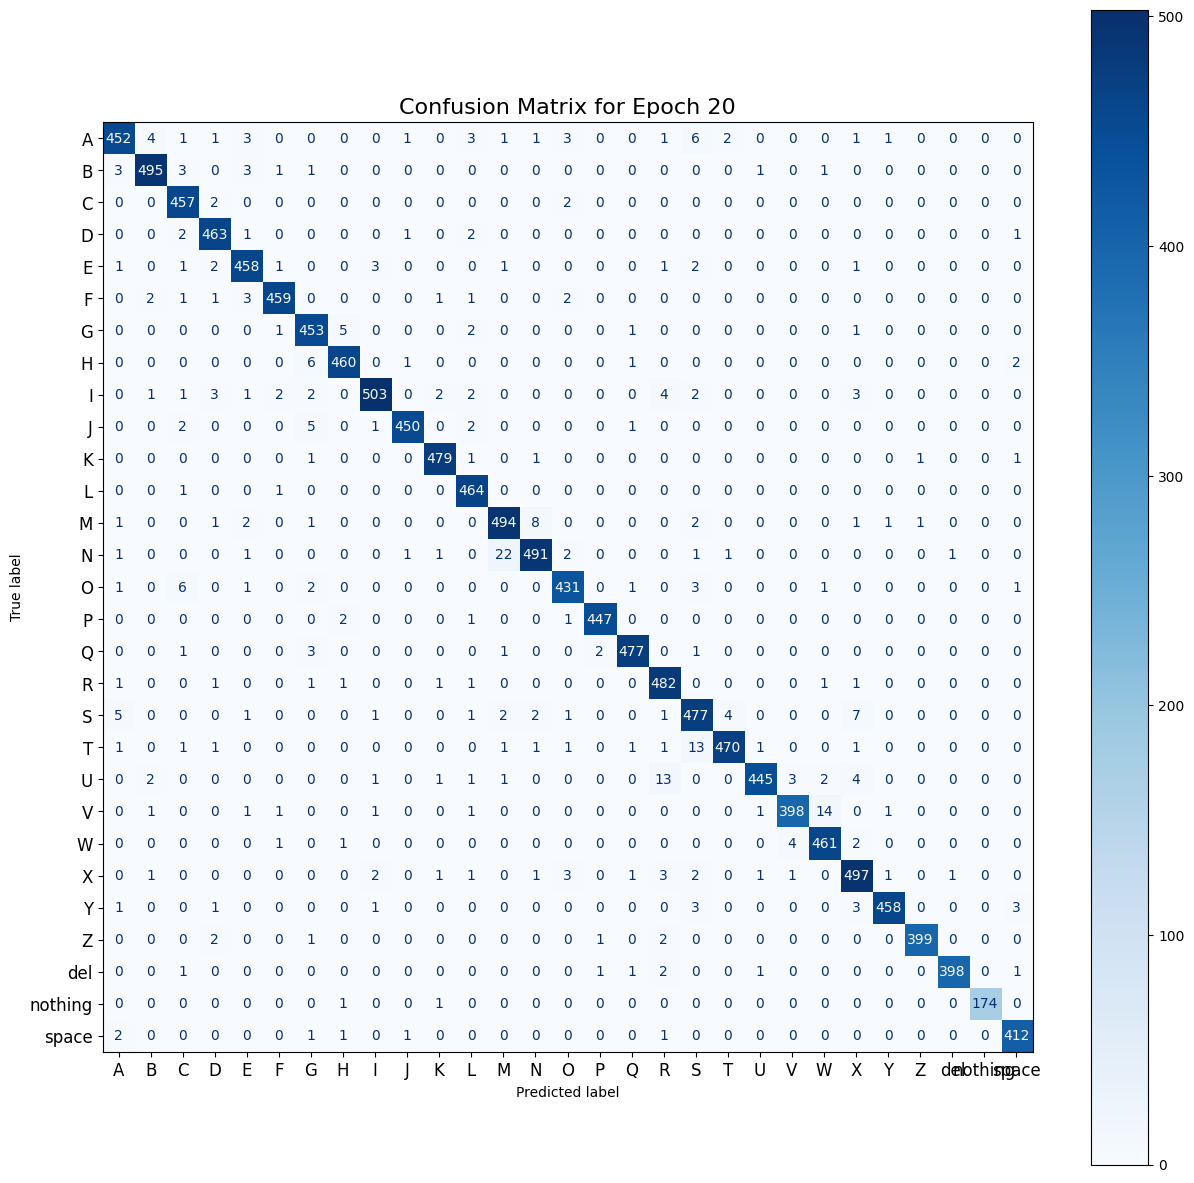

In [ ]:
# Increase the figure size to make numbers more readable
fig, ax = plt.subplots(figsize=(15, 15))  # Adjust the size as needed
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_loader.dataset.dataset.classes)
disp.plot(cmap='Blues', ax=ax)
plt.title(f"Confusion Matrix for Epoch {epoch + 1}", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()
